<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI286 - Computación Científica II</h1>
    <h1> Tarea 3: PDE Inpaiting </h1> 
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
</center>
<p>
<center>Diciembre 2019 - v1.0 </center>
</p>

---

In [1]:
import numpy as np
import scipy as sp
#import imutils
import matplotlib.pyplot as plt
from numpy import linalg as la
from matplotlib.image import imread
from PIL import Image

## Contexto

_Inpaiting_ es el proceso mediante el cual se busca mejorar la calidad o restaurar una imagen que ha sufrido alteraciones o deterioros. En nuestro caso, el objetivo será reparar una imagen a la que le falta un conjunto de bits.

<img src="example.png" style="float:center;height:200px">

Existen muchas técnicas para poder reconstruir los bits faltantes, y seguramente a usted ya se le habrán ocurrido algunas maneras utilizando tecnicas vistas en Computación Científica (interpolación polinomial, splines) o en otras asignaturas. En este laboratorio le presentaremos una nueva técnica basada en ecuaciones diferenciales parciales.

La ecuación de calor es una PDE que modela como la temperatura de un cuerpo sólido se comporta a través del tiempo. Esta es una PDE del tipo parabólica y tiene la siguiente forma:

\begin{equation}
    u_t = \sigma\,\Delta u,
\end{equation}
donde $\sigma$ es un coeficiente de difusión.
Esta ecuación también se conoce como ecuación de difusión, pues describe como un valor (en este caso temperatura) se disipa. Consideremos la siguiente variación:

$$
    u_t = \sigma_x\,u_{xx} + \sigma_y\,u_{yy},
$$

para "disipar" los valores de la imagen hacia los bits faltantes, donde $\sigma_x$ y $\sigma_y$ son valores reales. Un ejemplo del efecto de disipación sería el de la siguiente imagen:

<img src="dif.png" style="float:center;height:200px"><br>

Para definir el problema, debemos relacionar la EDP con la imagen y determinar cuales serían las condiciones iniciales y de borde apropiadas.
Consideremos que la imagen $I$ posee un conjunto de *missing values* en los pixeles $(c_x, c_y)$, de ancho $W$ y largo $H$.
Como se puede desprender de la imagen de ejemplo, las condiciones de borde corresponden a los pixeles conocidos que bordean al conjunto de *missing values* de la imagen. Esto significa que el dominio del problema corresponde a los *missing values* y los pixeles que rodean a este. Matemáticamente, podemos definir como dominio de la EDP  el conjunto $\Omega = [0, 1]^2$. La malla a utilizar para resolver numéricamente la EDP debe contener $W+2$ puntos en el eje $x$ (largo del dominio de *missing values* más dos puntos correspondientes a los pixeles conocidos) y $H+2$ puntos en el eje $y$. Sea $(x_i, y_j)$ un par en el borde del dominio, definiremos las condiciones de borde como

$$
    u(x_i, y_j, t) = I_{c_x+i, c_y+j}, \forall t > 0,
$$

donde $I_{n,m}$ corresponde al pixel en la posición $(n, m)$.

Para la condición inicial, idealmente necesitaríamos la imagen real (sin *missing values*). Sin embargo, esto es lo que deseamos encontrar. Sabemos que los pixeles al rededor de los *missing values* serán fijos (vienen de la imagen), por lo que podemos establecer cualquier valor arbitrario como valor inicial. Si consideramos que los pixeles son valores entre $0$ y $1$, entonces la condición inicial se define como:

$$
    u(x_i, y_j, 0) = 
    \begin{cases}
        I_{c_x+i, c_y+j}\quad&, \text{si }$(x_i, y_j)$ \text{corresponde al borde}, \\
        \alpha\quad&, \text{si }$(x_i, y_j)$ \text{corresponde a un punto interior},
    \end{cases}
$$
con $\alpha \in [0, 1]$.

Con esto tenemos los los elementos necesarios para aplicar *inpainting*! Un detalle importante es que la imagen es bidimensional, por lo que la EDP de calor tendrá dos dimensiones espaciales. 

## Sección 1 (60 puntos)

1. Discretice la ecuación de calor mediante Diferencias Finitas. Para el tiempo, utilice un esquema explícito.

Para poder obtener el Esquema explicito usaremos 2 aproximaciones, la primera sera para la 2da derivada parciales de variables espaciales, que es "Central Difference". La segunda para la variable temporal sera "Forward Difference":
Tomamos que $u(x,y,t) = U_{i,j,k}$

$\cdot$ Central Difference: 

$$
U_{xx} = \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2}
$$

$$
U_{yy} = \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2}
$$

Donde $\Delta$ es la diferencia entre los nodos vecinos, por lo que podemos decir que $\Delta x$ = $\Delta y$= 1

$\cdot$ Forward Difference: 

$$
U_{t} = \frac{U_{x,y,t+\Delta t} - U_{x,y,t}}{\Delta t}
$$

Luego debemos tomar lo anterior y reemplazarlo en la EDP original:

$$
    u_t = \sigma_x\,u_{xx} + \sigma_y\,u_{yy},
$$


Nos queda de la siguiente forma:

$$
\frac{U_{x,y,t+\Delta t} - U_{x,y,t}}{\Delta t} = \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2}
$$ 

Como dice el enunciado, es necesario encontrar $u_{x,y,t}$ que serian los missing values, por lo que debemos en la ecuacion anterior despejar:

$$
{U_{x,y,t+\Delta t} - U_{x,y,t}} = {\Delta t} \cdot \left( \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2} \right)
$$ 

$$
{U_{x,y,t+\Delta t}}  =  U_{x,y,t} + {\Delta t} \cdot \left( \sigma_x \cdot \frac{U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}{\Delta x^2} + \sigma_y \cdot \frac{U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}}{\Delta y^2} \right)
$$ 

$$
{U_{x,y,t+\Delta t}}  =  U_{x,y,t} + \frac{\Delta t}{\Delta x^2} \cdot \sigma_x \cdot\left(  {U_{x+\Delta x,y,t} - 2U_{x,y,t} + U_{x-\Delta x,y,t}}\right)  + \frac{\Delta t}{\Delta y^2}\cdot \cdot \sigma_y \cdot\left( {U_{x,y+\Delta y,t} - 2U_{x,y,t} + U_{x,y-\Delta y,t}} \right)
$$ 

2. Implemente un algoritmo que encuentre el sector de la imagen que posee los *missing values*, donde la imagen es representada como una matriz de *numpy*. Los *missing values* serán identificados mediante el valor `NaN`. Su algoritmo debe retornar la posición en donde empiezan los *missing values* (coordenada superior izquierda), y el ancho y largo del sector de *missing values*. Considere que los agujeros siempre tendrán forma rectangular.

In [2]:
'''
Input:
image - (array) matrix form of image
Output:
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
'''
def findHole(image):
    img_nan = read_image_with_nan(image+'.npy')
    img = read_image(image+'.png')
    print(img_nan)
    x,y  = np.shape(img_nan)
    auxX = 0
    c=0
    auxY = 0
    countX = 0
    countY = 0
    lista =  []
    for i in range(x):
        for j in range(y):
            if np.isnan(img_nan[i,j]) == True:
                lista.append([i,j])
                c = c+1
                if auxX < j:
                    auxX = j
                    countX = countX + 1
                if auxY < i:
                    auxY=i
                    countY = countY + 1
    start=(lista[0][0], lista[0][1])    
    width=countX
    lenght=countY
    return start, width, lenght

In [ ]:
findHole('wave')

In [ ]:
img_nan[start[0]-1:start[0]+lenght+1,start[1]-1:start[1]+width+1]

Puede utilizar la siguiente función para cargar las imágenes con *missing values* (valores `NaN`):

y la siguiente función para cargar imágenes comunes:

In [3]:
# For npy files
def read_image_with_nan(path):
    return np.load(path, allow_pickle=True)

In [4]:
# For PNG files
def read_image(path):
    return imread(path, format='png')

In [5]:
img_nan = read_image_with_nan('wave.npy')
img = read_image('wave.png')

In [ ]:
img_nan = read_image_with_nan('train_images/im2.npy')
img = read_image('train_images/im2.png')

In [ ]:
#start , width ,lenght = findHole('test_images/im2')
#start , width ,lenght = findHole('wave')
#test = np.zeros((c, b))
#np.shape(test)
#findHole('test_images/im2')
#findHole('wave')
start , width ,lenght = findHole('train_images/im2')
print("start ...\n", start)
print("width ...\n", width )
print("lenght ...\n", lenght)


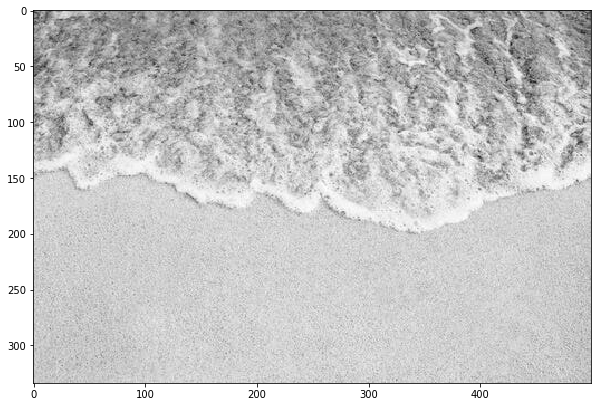

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

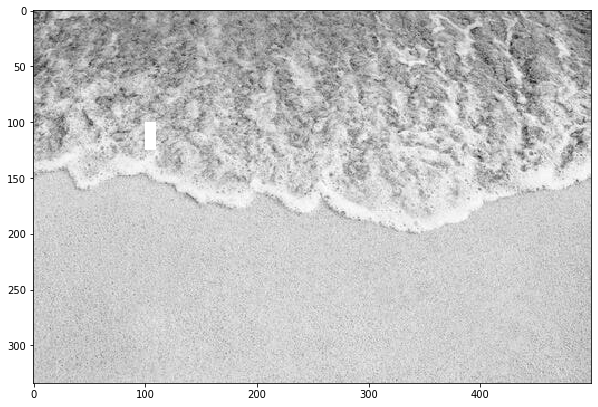

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(img_nan, cmap='gray')

In [ ]:
print(np.ndim(img_nan))
print(np.shape(img_nan))

3. Notar que la ecuación de calor está definida para todo $t > 0$. Sin embargo, sabemos que al ser difusiva tendrá un estado estacionario. Implemente un algoritmo que construya los pixeles faltantes de una imagen mediante el método planteado. Su algoritmo debe recibir la imagen a reconstruir, la ubicación de los pixeles faltantes, el valor $\alpha$ de inicio para la condición inicial, el coeficiente de difusión $\sigma$ y el *timestep*. Su algoritmo debe iterar hasta que se llegue a un estado aproximadamente estacionario. Indique como estimará si se ha llegado o no a dicho estado y justifique su elección.

In [8]:
#Usamos imgCen para ver la imagen donde se encuentran los NaN con sus respectivos bordes
#def imgCen(image , lenght , width , start):
#    imgCentral = np.zeros((lenght+2,width+2))
#    print("------shape imgcentral zeros\n",np.shape(imgCentral))
#    c1 = start[0]-1
#    c2 = start[1]-1 
#    for i in range(0, lenght+2):
#        for j in range(0, width+2):
#                imgCentral[i,j] = image[(c1 + i),  (c2 + j)]
#    print("Shape imgCentral----\n", np.shape(imgCentral))
#    print("imgCentral----\n", imgCentral[1])
#
#    return imgCentral

#Código modificado del JupyterNotebook del Curso, U4_HeatEquation

# This is the 2D version of Explicit Finite Differences

#evolve solo lo hace para una iteracion aplicando la ecuacion discretizada, esto para u que contiene los nan y los bordes
#Luego se retorna la u_new que seria la modificacion de u_old. Ademas se modifico D, ya que en este caso tenemos asignado
#sigma para x e y respectivos

def evolve(u_new, u_old, dt, sigmax,sigmay, dx2, dy2):
    u_new[1:-1, 1:-1]  = u_old[1:-1, 1:-1]
    u_new[1:-1, 1:-1] += sigmax * dt * (u_old[2:, 1:-1] - 2*u_old[1:-1, 1:-1] + u_old[:-2, 1:-1]) / dx2 
    u_new[1:-1, 1:-1] += sigmay * dt * (u_old[1:-1, 2:] - 2*u_old[1:-1, 1:-1] + u_old[1:-1, :-2]) / dy2
    return u_new

####################################################
# MAIN 2D-PARABOLIC FeUNCTION SOLVER
####################################################
#

#solver resuelve la u para los valores dados. Nx e Ny son las dimensiones respectivas. 
def solver(u0,sigmax, sigmay ,Nx=100, Ny=100, num_steps=10):
    verbose=True
    dx = 1./Nx
    dy = 1./Ny
    dx2 = dx**2
    dy2 = dy**2
    
    # For stability, this is the largest interval possible
    # for the size of the time-step:
    dt = 1.0*dx2*dy2 / ( 2*sigmax*sigmay*(dx2+dy2) )
    
    u_aux = u0
    u = u_aux
    #u = np.zeros([Nx,Ny])
    all_sims = np.zeros([num_steps, Nx, Ny])
    
    # Iterative step
    for n in range(num_steps): 
        u = evolve(u, u_aux, sigmax,sigmay, dt, dx2, dy2)    
        u_aux = u
        all_sims[n,:,:] = u
        if n%100 == 0: 
            #print("Shape u evolve", np.shape(u))
            #print("Shape all_sims evolve", np.shape(all_sims))
            #print("Iteracion n", n)
            #print("imagen y luego de evolve" , u)
            print("Este valor toma n \n",n)
            print("Esto es U\n ", u)
    #Debemos tener un criterio de parada, el cual determine el momento en el que se produce un estado estacionario    
        #if la.norm(all_sims[n,:,:]-all_sims[n-1,:,:], 'fro') < 10e-20:
            #return all_sims[:n,:,:]
    return all_sims

In [ ]:
print("Inicio\n",start)
print("Ancho\n",width)
print("Largo\n",lenght)
print("Dimensiones\n", np.shape(img_nan))
print("----Imagen Centrada NaN-----\n")
#print(imgCen(img_nan,lenght,width,start))


In [ ]:
#u = imgCen(img_nan,lenght,width,start)
#u2 = np.nan_to_num(u)
#u_aux = u2
#w = evolve(u_aux, u2, 1, 0.3,0.2, 1, 1)
#print(u2[-2])
#print(w[-2])
#solver(u2,1.0, 1.0,32,52,100)

In [ ]:
#print(np.nan_to_num(u))

In [9]:
'''
Input:
image - (array) matrix form of image
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
alpha - (float) A fixed value for initial condition
sigmax - (float) Fist difussion coefficient
sigmay - (float) Second difussion coefficient
dt - (float) time step
Output:
newImage - (array) matrix form of reconstructed image
'''
def fillHole(image, start, lenght, width, alpha, sigmax, sigmay, dt):
    newImage=image
    verbose = True
    if verbose: print("Coordenadas X:{0}-{1} \nCoordenadas Y:{2}-{3}".format(start[0],start[0]+width, start[1],start[1]+lenght))
    #seleccionamos la imagen con sus condiciones de borde.
    #image = image[start[1]-1:start[1]+lenght+2,start[0]-1:start[0]+width+2]
    #reemplazando valores NaN con el valor alpha entregado como parametro
    image = image[start[0]-1:start[0]+lenght+1,start[1]-1:start[1]+width+1]
    #print("imagen-------------",image)
    Nx, Ny = np.shape(image)
    image[1:-1,1:-1] = alpha
    #print("imagen-------------alpha",image)
    #aplicamos el solver
    #print("Nx-Ny", Nx,Ny)
    image = solver(image, sigmax, sigmay, Nx, Ny, 1000)
    #print(np.shape(image[0]))
    #print(np.shape(image))
    #reemplazamos la aproximacion obtenida en la imagen original
    #print("Shape newImage",np.shape(newImage))
    #print("Shape img Solver------", np.shape(image))
    #print("START---FUNCION", start)
    #print("lenght --- width" , lenght, width)

    newImage[start[0]-1:start[0]+lenght+1,start[1]-1:start[1]+width+1]= image[-2,:,:]
    return newImage
    #return image[-2,:,:]

[[0.54509807 0.7137255  0.8039216  ... 0.69411767 0.5921569  0.46666667]
 [0.49803922 0.5529412  0.63529414 ... 0.69803923 0.60784316 0.52156866]
 [0.52156866 0.49411765 0.4862745  ... 0.57254905 0.5176471  0.4862745 ]
 ...
 [0.8392157  0.8666667  0.8745098  ... 0.83137256 0.8235294  0.7529412 ]
 [0.827451   0.85882354 0.8627451  ... 0.8392157  0.87058824 0.83137256]
 [0.8509804  0.8627451  0.84705883 ... 0.84705883 0.85882354 0.79607844]]
start - lenght - width (100, 100) 25 10
Coordenadas X:100-110 
Coordenadas Y:100-125
Este valor toma n 
 0
Esto es U
  [[8.3529413e-01 8.8235295e-01 8.9411765e-01 8.2745099e-01 8.5098040e-01
  8.7058824e-01 8.1568629e-01 8.5490197e-01 8.6666667e-01 8.5098040e-01
  8.7058824e-01 8.6274511e-01]
 [8.3137256e-01 5.9096088e+02 6.4709619e+02 6.0863470e+02 6.2012891e+02
  6.3017902e+02 6.0029401e+02 6.2157306e+02 6.3014954e+02 6.2248669e+02
  5.8120648e+02 8.4313726e-01]
 [8.5490197e-01 7.0507377e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00

/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in true_divide
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in multiply
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in subtract
/Users/Akame1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in add


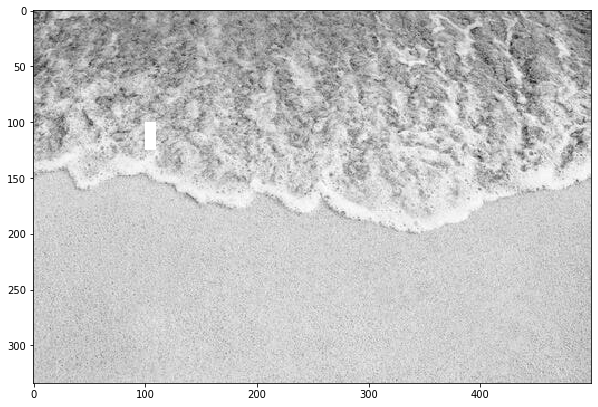

In [10]:
#img_nan = read_image_with_nan('train_images/im2.npy')
#start, width,lenght= findHole('train_images/im2')
img_nan = read_image_with_nan('wave.npy')
start, width, lenght = findHole('wave')
print("start - lenght - width", start , lenght , width)
alpha   = 0
sigmax  = 1
sigmay  = 1
dt      = 1
img_filled = fillHole(img_nan, start, lenght,width,alpha, sigmax, sigmay, dt)

plt.figure(figsize=(10, 10))
plt.imshow(img_filled, cmap='gray')

4. Evalúe su implementación con los valores de $\sigma_x = \sigma_y = 1$ y $\alpha = 0$. Comente en función de los resultados obtenidos.

## Sección 2 (60 puntos)

1. Aplique su algoritmo de la Sección 1 para distintos valores de $\sigma_x$, $\sigma_y$, $\alpha$ y *timestep*. Concluya al respecto. Recuerde considerar la estabilidad en la variación de los valores de $\sigma_x$ y $\sigma_y$.

2. Utilice la *Normal de Frobenius* para medir el error entre la imagen con *inpainting* y la imagen original. Mida el error para distintos valores de $\sigma_x$, $\sigma_y$, $\alpha$ y *timestep*. Concluya al respecto.

3. Proponga un algoritmo que permita *optimizar* el valor de $\sigma_x$ y $\sigma_y$ respecto a la norma de Frobenius. Para esta sección elija un valor de $\alpha$ fijo, en función de los experimentos realizados en las preguntas 1 y 2 de la sección 2. Su algoritmo debe *optimizar* utilizando las imágenes dentro de la carpeta `train_images`. Una vez obtenidos los valores de $\sigma_x$ y $\sigma_y$, evalúe el desempeño con las imágenes de `train_images`. Comente y concluya en función de sus resultados.

## Sección 3 (50 puntos)

1. Discretice la ecuación de calor para usarla en este problema, usando un esquema implícito. Incluya una imagen de los stencil explícitos e implícitos y comparelos.

2. Modifique el código desarrollado en la pregunta 3 de la sección anterior para que reconstruya la imagen usando un esquema implícito. 

In [ ]:
'''
Input:
image - (array) matrix form of image
start - (array) coordenates of hole's corner
width - (int) horizontal size of hole
lenght - (int) vertical size of hole
alpha - (float) A fixed value for initial condition
sigmax - (float) Fist difussion coefficient
sigmay - (float) Second difussion coefficient
dt - (float) time step
Output:
newImage - (array) matrix form of reconstructed image
'''
def fillHoleImplicit(image, start, width, lenght, alpha, sigmax, sigmay, dt):
    newImage=image
    #...
    return newImage

3. Utilice la *Normal de Frobenius* para medir el error entre la imagen con *inpainting* y la imagen original. Mida el error para distintos *timestep*. Concluya en función de los resultados y en comparación con el uso de un método explícito.

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

---

# Referencias
